# SEPSIS PREDICTION (A CLASSIFICATION PROJECT)

## Data understanding

The project is about how to determine wether patients are likely to get sepsis.

According to the Mayo Clinic "Sepsis is a serious condition in which the body responds improperly to an infection. The infection-fighting processes turn on the body, causing the organs to work poorly.

Sepsis may progress to septic shock. This is a dramatic drop in blood pressure that can damage the lungs, kidneys, liver and other organs. When the damage is severe, it can lead to death.

Early treatment of sepsis improves chances for survival."

In this dataset we have been provided with some features/Key indicator that could lead to sepsis in patients, we will be using this information to train machine learning models to determine which of the conditions could lead to sepsis.

### Full meaning of columns
- ID: number to represent patient ID
- PRG: Plasma glucose
- PL: Blood Work Result-1 (mu U/ml)
- PR: Blood Pressure (mm Hg)
- SK: Blood Work Result-2 (mm)
- TS: Blood Work Result-3 (mu U/ml)
- M11: Body mass index (weight in kg/(height in m)^2
- BD2: Blood Work Result-4 (mu U/ml)
- Age: patients age (years)
- Insurance: If a patient holds a valid insurance card
- Sepsis: Positive: if a patient in ICU will develop a sepsis , and Negative: means otherwise.

### Null Hypothesis
- Age does not affect the chances of developing sepsis

### Alternate hypothesis
- Age is a significant factor in developing sepsis

In [2]:
# Libraries for EDA and loading data
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Library for Hypothesis testing
from scipy.stats import chi2_contingency

# Libraries for preprocessing
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

# To balance dataset
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

# For Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Importing Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# For persisting models and encoder
import joblib

# Libraries for filtering warnings
from warnings import filterwarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('.\data\Patients_Files_Train.csv')

test_df = pd.read_csv('.\data\Patients_Files_Train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PRG,599.0,3.824708,3.362839,0.000,1.000,3.000,6.000,17.00
PL,599.0,120.153589,32.682364,0.000,99.000,116.000,140.000,198.00
PR,599.0,68.732888,19.335675,0.000,64.000,70.000,80.000,122.00
SK,599.0,20.562604,16.017622,0.000,0.000,23.000,32.000,99.00
TS,599.0,79.460768,116.576176,0.000,0.000,36.000,123.500,846.00
M11,599.0,31.920033,8.008227,0.000,27.100,32.000,36.550,67.10
BD2,599.0,0.481187,0.337552,0.078,0.248,0.383,0.647,2.42
Age,599.0,33.290484,11.828446,21.000,24.000,29.000,40.000,81.00
Insurance,599.0,0.686144,0.464447,0.000,0.000,1.000,1.000,1.00


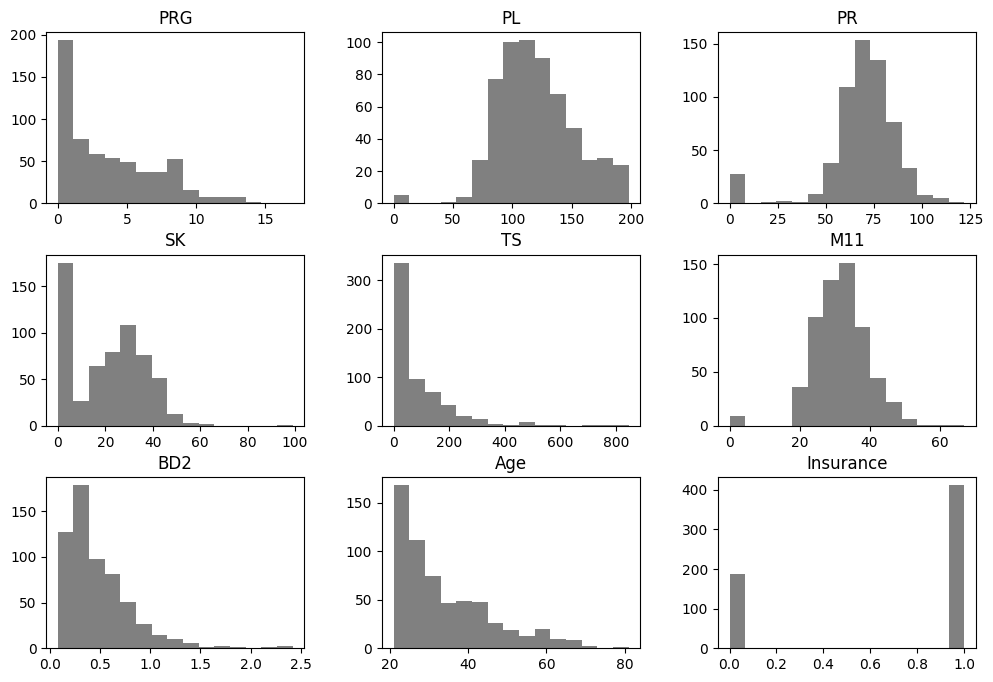

In [6]:
df.hist(figsize=(12, 8), color='grey', grid=False, bins=15)
plt.show()

In [7]:
df.duplicated().sum()

np.int64(0)

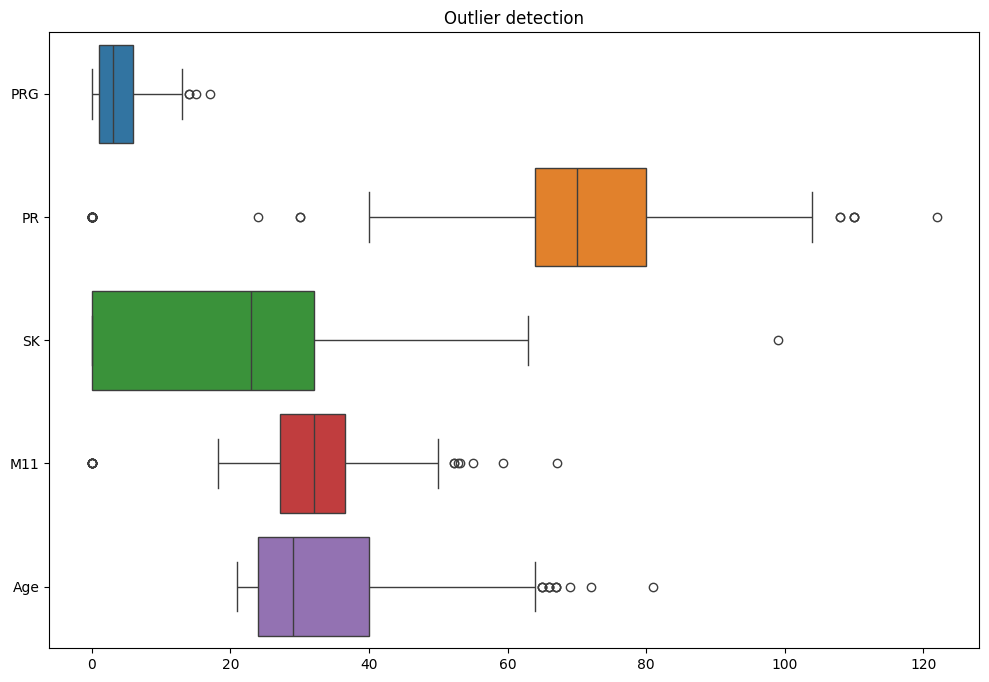

In [8]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df.drop(['ID', 'Insurance', 'Sepssis', 'TS', 'PL', 'BD2'], axis=1), orient='h')
plt.title('Outlier detection')
plt.show()

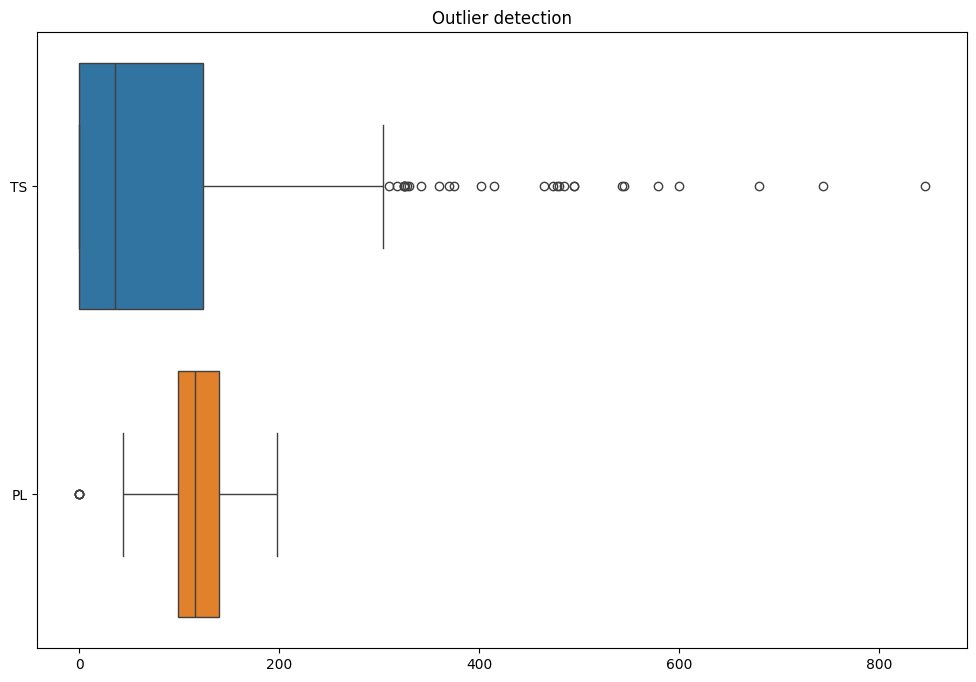

In [9]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df[['TS', 'PL',]], orient='h')
plt.title('Outlier detection')
plt.show()

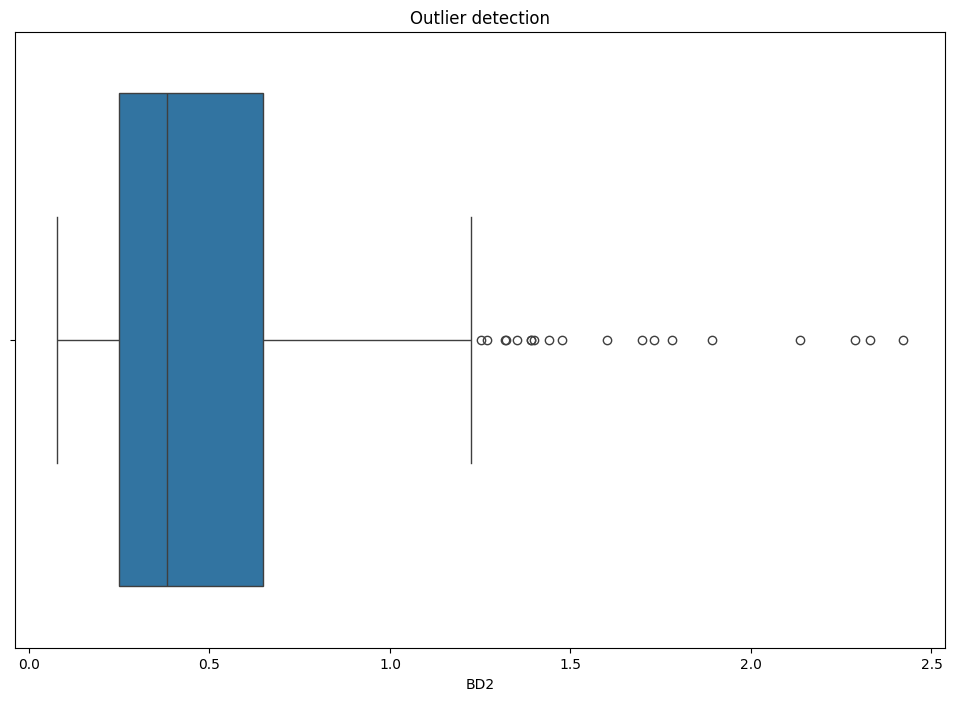

In [10]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df['BD2'], orient='h')
plt.title('Outlier detection')
plt.show()

In [11]:
numeric_columns = df.select_dtypes(include=['number'])
corr = numeric_columns.drop('Insurance', axis=1).corr()
corr

,PRG,PL,PR,SK,TS,M11,BD2,Age
PRG,1.000000,0.139541,0.116680,-0.080902,-0.054812,0.033482,-0.052230,0.532545
PL,0.139541,1.000000,0.143064,0.054430,0.339818,0.215949,0.144665,0.274057
PR,0.116680,0.143064,1.000000,0.197535,0.095281,0.269482,0.008318,0.225625
SK,-0.080902,0.054430,0.197535,1.000000,0.429068,0.377950,0.176592,-0.121553
TS,-0.054812,0.339818,0.095281,0.429068,1.000000,0.184747,0.218313,-0.011523
M11,0.033482,0.215949,0.269482,0.377950,0.184747,1.000000,0.127675,0.046117
BD2,-0.052230,0.144665,0.008318,0.176592,0.218313,0.127675,1.000000,0.033567
Age,0.532545,0.274057,0.225625,-0.121553,-0.011523,0.046117,0.033567,1.000000


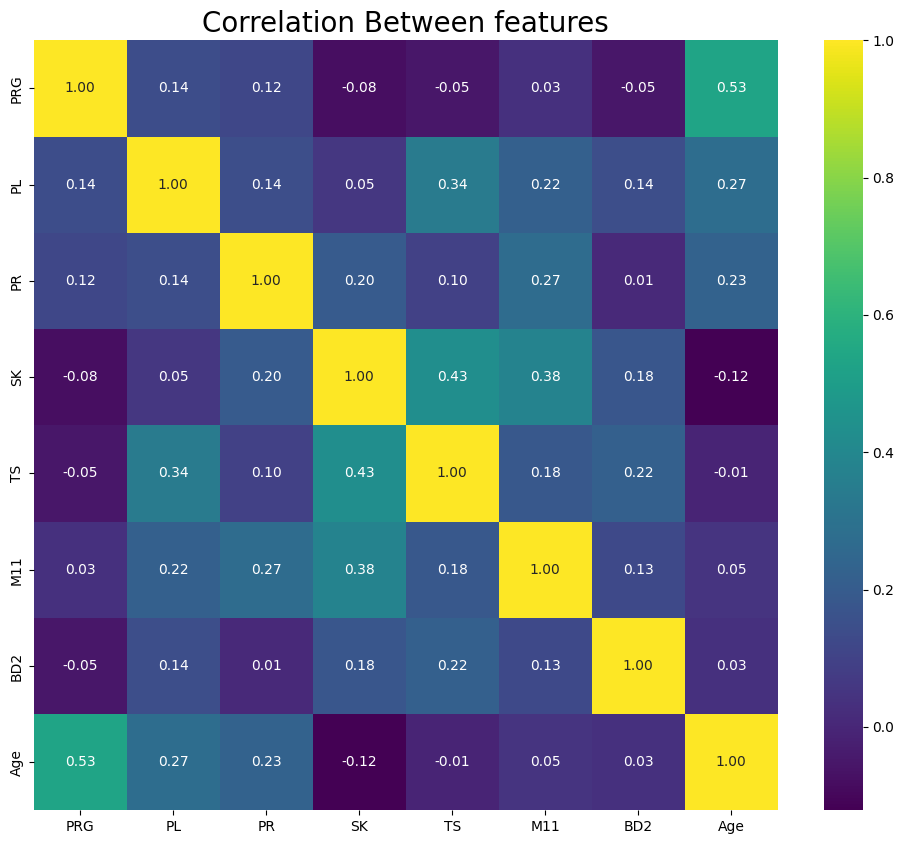

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Between features', fontsize=20)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

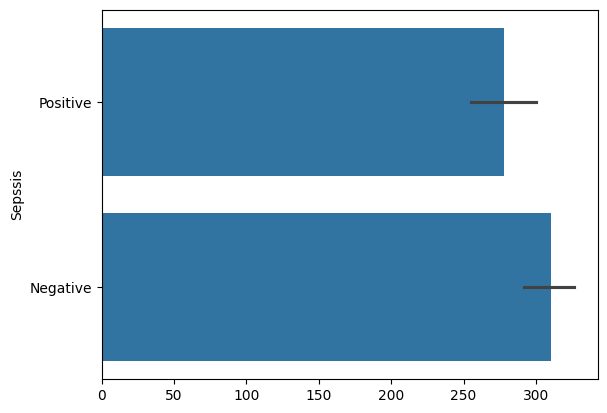

In [13]:
sns.barplot(df['Sepssis'])
plt.show

In [14]:
print(f"The percentage of patients who did not develop Sepsis is {round(df['Sepssis'].value_counts()[0]/len(df['Sepssis'])*100, 2)}%")
print(f"The percentage of patients who developed Sepsis is {round(df['Sepssis'].value_counts()[1]/len(df['Sepssis'])*100, 2)}%")

The percentage of patients who did not develop Sepsis is 65.28%
The percentage of patients who developed Sepsis is 34.72%


### Hypothesis Test

In [15]:
# Create a contingency table of age and sepsis
contingency_table = pd.crosstab(df['Age'], df['Sepssis'])

# Perform chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

alpha = 0.01

# Print the chi-square test results
print("Chi-square test results:")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value:.9f}")

print('---------------------------------------------------------------------------------')
if p_value < alpha:
    print('We reject the null Hypothesis because Age has a significant effect on Sepsis')
else:
    print('We fail to reject the Null Hypothesis because Age has no significant effect on Sepsis')

print('---------------------------------------------------------------------------------')

Chi-square test results:
Chi-square statistic: 120.0398504698636
P-value: 0.000000068
---------------------------------------------------------------------------------
We reject the null Hypothesis because Age has a significant effect on Sepsis
---------------------------------------------------------------------------------


## Data preparation for Pipelines

In [16]:
df_train = df.drop(['ID', 'Insurance'], axis=1)
df_train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Sepssis
0,6,148,72,35,0,33.6,0.627,50,Positive
1,1,85,66,29,0,26.6,0.351,31,Negative
2,8,183,64,0,0,23.3,0.672,32,Positive
3,1,89,66,23,94,28.1,0.167,21,Negative
4,0,137,40,35,168,43.1,2.288,33,Positive
...,...,...,...,...,...,...,...,...,...
594,6,123,72,45,230,33.6,0.733,34,Negative
595,0,188,82,14,185,32.0,0.682,22,Positive
596,0,67,76,0,0,45.3,0.194,46,Negative
597,1,89,24,19,25,27.8,0.559,21,Negative


In [17]:
X = df_train.drop('Sepssis', axis=1)
y = df_train['Sepssis']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40, stratify=y)

In [19]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

### Models to be trained

In [20]:
# Create a list of models (Top 8 selected based on ChatGPT recommendation)
models = [
    ('Logistic_regression', LogisticRegression(random_state=42)),
    ('Decision_tree', DecisionTreeClassifier(random_state=42)),
    ('Random_forest', RandomForestClassifier(random_state=42)),
    ('Support_vector', SVC(random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Gradient_boost', GradientBoostingClassifier(random_state=42)),
    ('Naive_bayes', GaussianNB()),
    ('XGBoost', xgb.XGBClassifier(random_state=42))
]

### Fitting models

In [21]:
# Create a dictionary to store all pipelines
all_pipelines = {}

# Create Dictionary to store all confusion matrix
all_confusion_matrix = {}

metrics_table = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score'])

for model, classifier in models:    
    pipeline = Pipeline(steps=[
        ('num_scaler', RobustScaler()),
        ('impute', SimpleImputer(strategy='median')),
        ('feature_selection', SelectKBest(mutual_info_classif, k='all')), # Helps to select the best features 
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train_encoded)

    # Store the pipeline in the dictionary
    all_pipelines[model] = pipeline

    y_pred = pipeline.predict(X_test)

    metrics = classification_report(y_test_encoded, y_pred, output_dict=True)

    conf_matrix = confusion_matrix(y_test_encoded, y_pred)

    conf_matrix = confusion_matrix(y_test_encoded, y_pred)

    # Add confusion matrix to all pipelines
    all_confusion_matrix[model] = conf_matrix

    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score = metrics['weighted avg']['f1-score']

    metrics_table.loc[len(metrics_table)] = [model, accuracy, precision, recall, f1_score]

#Display metrics for all model in Descending order
metrics_table.sort_values(by='f1_score', ascending=False)

,model,accuracy,precision,recall,f1_score
0,Logistic_regression,0.806667,0.803658,0.806667,0.804189
2,Random_forest,0.786667,0.782184,0.786667,0.781961
3,Support_vector,0.786667,0.782169,0.786667,0.780497
6,Naive_bayes,0.773333,0.771467,0.773333,0.772256
4,KNN,0.760000,0.756340,0.760000,0.757600
5,Gradient_boost,0.746667,0.744533,0.746667,0.745462
7,XGBoost,0.726667,0.721344,0.726667,0.723164
1,Decision_tree,0.686667,0.688105,0.686667,0.687355


## Visualisation to show feature importance

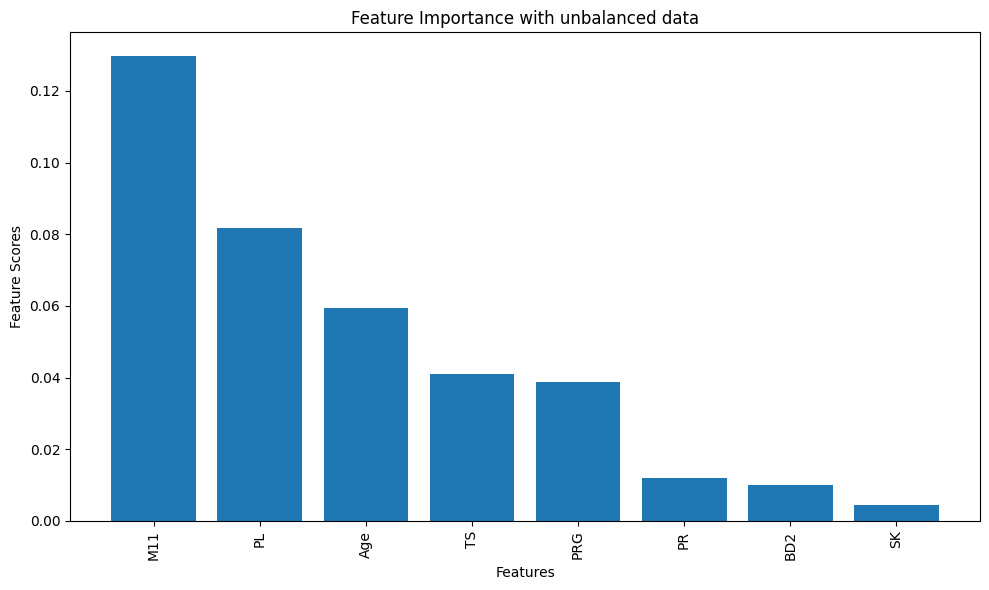

In [22]:
# Access the SelectKBest transformer from the pipeline
select_k_best = all_pipelines[model]['feature_selection']

# Get the feature scores from SelectKBest
feature_scores = select_k_best.scores_

# Get the names of all features
all_feature_names = X_train.columns

# Create a dictionary to store feature scores and names
feature_importance = dict(zip(all_feature_names, feature_scores))

# Sort the dictionary by feature scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get the feature names and scores separately
sorted_feature_names, sorted_scores = zip(*sorted_feature_importance)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_scores)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Scores')
plt.title('Feature Importance with unbalanced data')
plt.tight_layout()
plt.show()

### Fitting models with a balanced pipeline

In [23]:
# Create a dictionary to store all pipelines
all_bal_pipelines = {}

bal_metrics_table = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score'])

# Create final pipeline preprocessor and classifier
for model, classifier in models:
    bal_pipeline = imbpipeline([
        ('num_scaler', RobustScaler()),
        ('impute', SimpleImputer(strategy='median')),
        ('smote_sampler', SMOTE(random_state=42)),
        ('feature_selection', SelectKBest(mutual_info_classif, k='all')), # Helps to select the best features 
        ('classifier', classifier)
    ])

    # Fit data to pipeline
    bal_pipeline.fit(X_train, y_train_encoded)

    # Store the pipeline in the dictionary
    all_bal_pipelines[model] = bal_pipeline

    y_pred = bal_pipeline.predict(X_test)

    #Generate classification report for all pipelines
    bal_metrics = classification_report(y_test_encoded, y_pred, output_dict=True)

    accuracy = bal_metrics['accuracy']
    precision = bal_metrics['weighted avg']['precision']
    recall = bal_metrics['weighted avg']['recall']
    f1_score = bal_metrics['weighted avg']['f1-score']

    bal_metrics_table.loc[len(bal_metrics_table)] = [model, accuracy, precision, recall, f1_score]

#Display metrics for all model in Descending order
bal_metrics_table.sort_values(by='f1_score', ascending=False)

,model,accuracy,precision,recall,f1_score
6,Naive_bayes,0.786667,0.797333,0.786667,0.789747
2,Random_forest,0.746667,0.751844,0.746667,0.748719
7,XGBoost,0.713333,0.714657,0.713333,0.713963
0,Logistic_regression,0.706667,0.750844,0.706667,0.713731
3,Support_vector,0.693333,0.713769,0.693333,0.699195
5,Gradient_boost,0.686667,0.705251,0.686667,0.692337
1,Decision_tree,0.666667,0.683773,0.666667,0.672326
4,KNN,0.660000,0.696787,0.660000,0.668012


### Performing Hyperparameter tuning for all models

In [24]:
# Create a dictionary to store the best hyperparameters for each model
hyperparameters = {}

# Create a dictionary to store all pipelines
all_hype_pipelines = {}

hype_metrics_table = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1_score'])

# Perform hyperparameter tuning for each model
for model, final_pipeline in all_pipelines.items():
    if model == 'Logistic_regression':
        # Define the hyperparameters to tune for Logistic Regression
        param_grid = {
            'classifier__penalty': ['l2'],
            'classifier__C': [0.1, 1, 10]
        }
    elif model == 'Decision_tree':
        # Define the hyperparameters to tune for Decision Tree
        param_grid = {
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    elif model == 'Random_forest':
        # Define the hyperparameters to tune for Random Forest
        param_grid = {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [None, 5, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    elif model == 'Support_vector':
        # Define the hyperparameters to tune for Support Vector Machine
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    elif model == 'KNN':
        # Define the hyperparameters to tune for K-Nearest Neighbors
        param_grid = {
            'classifier__n_neighbors': [3, 5, 7]
        }
    elif model == 'Gradient_boost':
        # Define the hyperparameters to tune for Gradient Boosting
        param_grid = {
            'classifier__learning_rate': [0.1, 0.01],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 10]
        }
    elif model == 'XGBoost':
        # Define the hyperparameters to tune for XGBoost
        param_grid = {
            'classifier__learning_rate': [0.1, 0.01],
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 10]
        }
    elif model == 'Naive_bayes':
        param_grid = {
            'classifier__priors': [None, [0.2, 0.8], [0.5, 0.5], [0.8, 0.2]]
        }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=final_pipeline, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train_encoded)

    # Store the best hyperparameters in the dictionary
    hyperparameters[model] = grid_search.best_params_

    # Fit the model with the best hyperparameters
    best_pipeline = grid_search.best_estimator_
    best_pipeline.fit(X_train, y_train_encoded)

    # Store the pipeline in the dictionary
    all_hype_pipelines[model] = best_pipeline

    # Get the evaluation metrics for the best model
    y_pred = best_pipeline.predict(X_test)
    hype_metrics = classification_report(y_test_encoded, y_pred, output_dict=True)

    # Print the best hyperparameters and evaluation metrics for each model
    print(f"Model: {model}")
    print("Best Hyperparameters:", hyperparameters[model])

    print("----------------------------------------------")

    accuracy = hype_metrics['accuracy']
    precision = hype_metrics['weighted avg']['precision']
    recall = hype_metrics['weighted avg']['recall']
    f1_score = hype_metrics['weighted avg']['f1-score']

    hype_metrics_table.loc[len(hype_metrics_table)] = [model, accuracy, precision, recall, f1_score]

#Display metrics for all model in Descending order
hype_metrics_table.sort_values(by='f1_score', ascending=False)

Model: Logistic_regression
Best Hyperparameters: {'classifier__C': 1, 'classifier__penalty': 'l2'}
----------------------------------------------
Model: Decision_tree
Best Hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10}
----------------------------------------------
Model: Random_forest
Best Hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
----------------------------------------------
Model: Support_vector
Best Hyperparameters: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
----------------------------------------------
Model: KNN
Best Hyperparameters: {'classifier__n_neighbors': 5}
----------------------------------------------
Model: Gradient_boost
Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}
----------------------------------------------
Model: Naive_bayes
Best Hyperparameters: {'classifier__priors': N

,model,accuracy,precision,recall,f1_score
3,Support_vector,0.813333,0.810776,0.813333,0.807935
0,Logistic_regression,0.806667,0.803658,0.806667,0.804189
2,Random_forest,0.793333,0.789576,0.793333,0.786602
6,Naive_bayes,0.773333,0.771467,0.773333,0.772256
5,Gradient_boost,0.766667,0.760677,0.766667,0.759067
4,KNN,0.760000,0.756340,0.760000,0.757600
7,XGBoost,0.706667,0.694114,0.706667,0.678667
1,Decision_tree,0.646667,0.639031,0.646667,0.642139


### Plotting ROC/AUC Curve

An error occurred for model 'Support_vector': This 'Pipeline' has no attribute 'predict_proba'


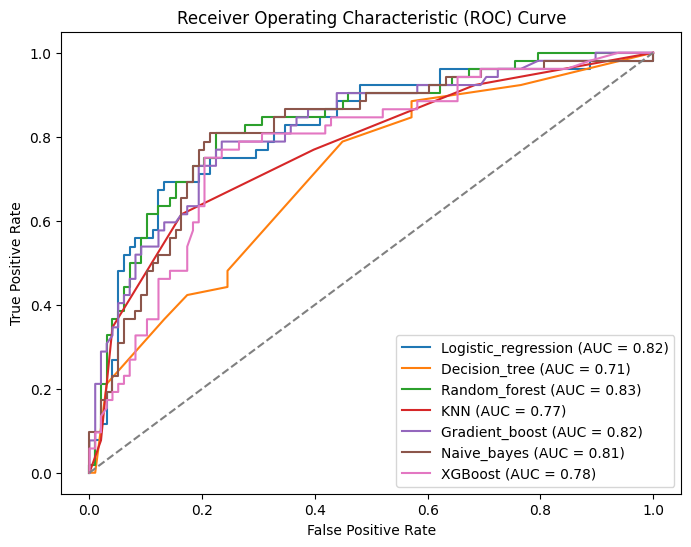

In [25]:
# Create a dictionary to store the AUC scores for each model
auc_scores = {}

# Calculate the ROC curve and AUC score for each model
plt.figure(figsize=(8, 6))
for model, pipeline in all_hype_pipelines.items():
    try:
        y_scores = pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test_encoded, y_scores)
        auc_scores[model] = roc_auc_score(y_test_encoded, y_scores)
        plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_scores[model]:.2f})')
    except Exception as e:
        print(f"An error occurred for model '{model}': {str(e)}")
        continue

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Set the plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend
plt.legend(loc='lower right')

# Display the ROC AUC curve
plt.show()

### Persisting Model Pipelines and Encoder for API

In [26]:
# A for loop to iterate over names and pipelines then save them to the folder
for model, pipeline in all_hype_pipelines.items():
    joblib.dump(pipeline, f'./models and encoder/{model}_pipeline.joblib')

In [27]:
# Persist encoder used to encode the target variable
joblib.dump(encoder, './models and encoder/encoder.joblib')

['./models and encoder/encoder.joblib']

In [28]:
X.columns

Index(['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age'], dtype='object')